In [1]:
import sys
print(sys.executable)

C:\Users\Erik\PycharmProjects\fallstudie_model_engineering\.venv\Scripts\python.exe


In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split

from src.config import RAW_DATA_PATH
from src.features import engineer_features

from src.models import (
    train_decision_tree,
    train_hgboost,
    tune_hyperparameters,
)
from src.metrics import (
    get_scores,
    plot_confusion_matrix,
    plot_precision_recall_curve,
    plot_multiple_precision_recall_curves,
)

In [4]:
raw_data = pd.read_excel(RAW_DATA_PATH, index_col=0)

In [5]:
processed_data, ohc = engineer_features(data=raw_data)

In [6]:
# Split features and target
y = processed_data["success"]
X = processed_data.drop(columns=["success"], axis=1)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

Train Models

In [7]:
dtm = train_decision_tree(x_train=X_train, y_train=y_train)

In [10]:
hgbm = train_hgboost(x_train=X_train, y_train=y_train)

In [9]:
ohgbm = tune_hyperparameters(x_train=X_train, y_train=y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Beste Parameter gefunden: {'l2_regularization': np.float64(0.23956189066697242), 'learning_rate': np.float64(0.03897897441824462), 'max_depth': 14, 'max_iter': 317, 'min_samples_leaf': 51}
Bester CV f1-Score: 0.4236


In [11]:
models_to_evaluate = {
    "decision_tree_model": dtm,
    "hgboost_model": hgbm,
    "optimized_hgboost_model": ohgbm,
}

In [12]:
# Evaluate models - technical score
print("\n--- Model Evaluation Scores ---")
for name, model in models_to_evaluate.items():
    precision, recall, roc_auc, cm = get_scores(
        name=name, model=model, y_true=y_test, x_test=X_test
    )
    print("Model Name:   ", name)
    print("Precision:    ", round(precision, 4))
    print("Recall:       ", round(recall, 4))
    print("ROC-AUC:      ", round(roc_auc, 4))
    print("\n")



--- Model Evaluation Scores ---
Model Name:    decision_tree_model
Precision:     0.5291
Recall:        0.0524
ROC-AUC:       0.6565


Model Name:    hgboost_model
Precision:     0.3008
Recall:        0.7426
ROC-AUC:       0.6824


Model Name:    optimized_hgboost_model
Precision:     0.2965
Recall:        0.7483
ROC-AUC:       0.6837




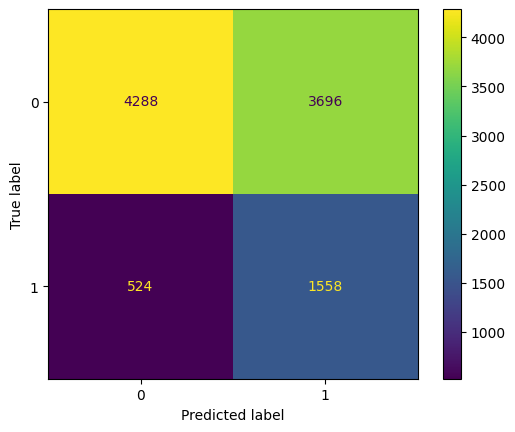

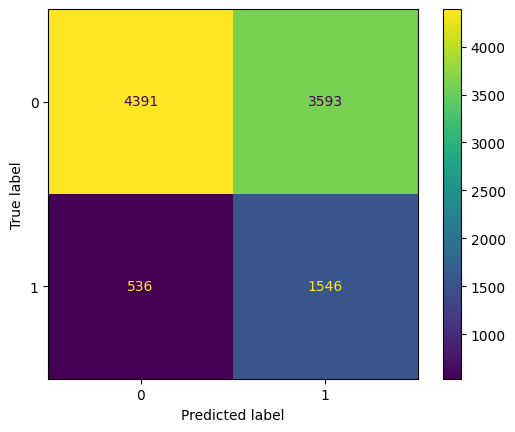

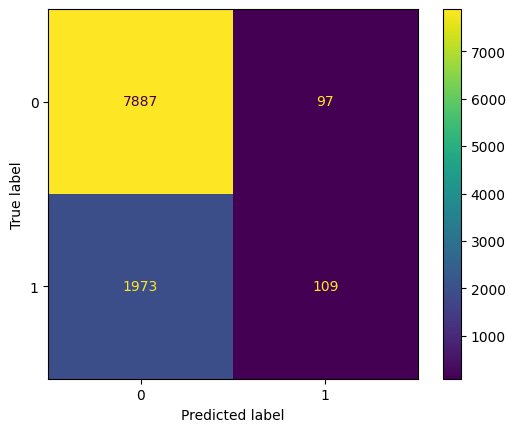

In [25]:
plot_confusion_matrix(x_test=X_test, y_test=y_test, model=ohgbm)
plot_confusion_matrix(x_test=X_test, y_test=y_test, model=hgbm)
plot_confusion_matrix(x_test=X_test, y_test=y_test, model=dtm)

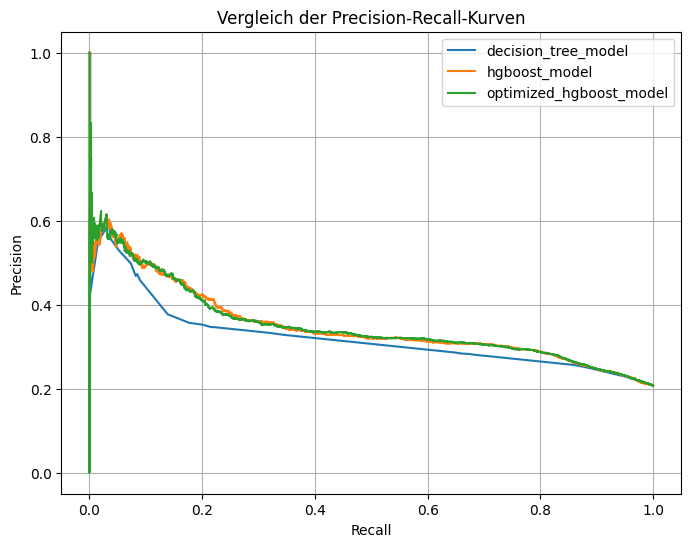

In [26]:
plot_multiple_precision_recall_curves(x_test=X_test, y_test=y_test, models=models_to_evaluate)